In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys, os
import numpy as np
import cv2
sys.path.append('../external/cocoapi/PythonAPI/')
from pycocotools.coco import COCO
sys.path.append('../external/maskrcnn-benchmark/demo')
sys.path.append('../external/maskrcnn-benchmark')
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

In [2]:
sys.path.append('../')
from src import user_input_simulation
from src.image_helpers import iou, get_largest_annotation

In [3]:
np.random.seed(0)

In [4]:
# Image dirs
dataDir = '../../data/input/coco'
print(os.listdir(dataDir))
dataType = 'val2017'
annDir = '{}/annotations'.format(dataDir)
annZipFile = '{}/annotations_train{}.zip'.format(dataDir, dataType)
annFile = '{}/instances_{}.json'.format(annDir, dataType)
imgDir = '{}/images/{}'.format(dataDir, dataType)
print (annDir)
print (annFile)
print (annZipFile)
print (imgDir)

['images', 'annotations']
../../data/input/coco/annotations
../../data/input/coco/annotations/instances_val2017.json
../../data/input/coco/annotations_trainval2017.zip
../../data/input/coco/images/val2017


In [5]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


In [6]:
# get all images containing given categories, select one at random
imgIds = coco.getImgIds();
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# img = coco.loadImgs(347544)[0]
# id = 347544

In [7]:
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

{'license': 4, 'file_name': '000000065350.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000065350.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-20 05:15:48', 'flickr_url': 'http://farm5.staticflickr.com/4139/4869131880_ae3de10447_z.jpg', 'id': 65350}


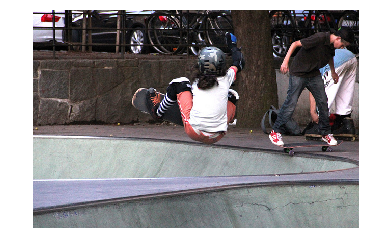

In [8]:
I = cv2.imread(os.path.join(imgDir, img['file_name']))
plt.axis('off')
imshow(I)
print(img)

In [9]:
largest_annotation = get_largest_annotation(coco, img['id'])
largest_mask = coco.annToMask(largest_annotation)

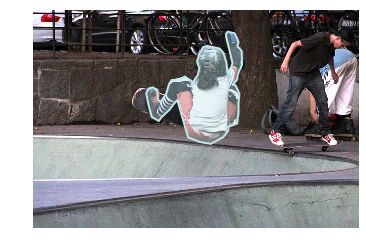

In [10]:
imshow(I)
coco.showAnns([largest_annotation])

In [11]:
class GrabCutModel:
    def __init__(self, img):
        self.img = img
        self.mask = np.zeros(img.shape[:2], np.uint8)
        print(self.mask.shape)
    
    def get_output_mask(self):
        return np.where((self.mask==2)|(self.mask==0), 0, 1).astype('uint8')
    
    def get_output_image(self):
        output_mask = self.get_output_mask()
        return I*output_mask[:,:,np.newaxis]
    
    def init_iteration(self, rect):
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        cv2.grabCut(self.img, self.mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    def mask_iteration(self, user_input):
        self.mask[user_input == user_input_simulation.BG_COLOR] = 0
        self.mask[user_input == user_input_simulation.FG_COLOR] = 1
        bgdModel = np.zeros((1,65),np.float64)
        fgdModel = np.zeros((1,65),np.float64)
        cv2.grabCut(self.img, self.mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
    
    # Returns all masks, and iou data for visualization and statistics purposes
    def multiple_iterations(self, gt, rect, iterations):
        mask_array = []
        user_input_array = []
        image_array = []
        iou_array = []

        # Rectangle init
        self.init_iteration(rect)

        mask_array.append(self.get_output_mask())
        image_array.append(self.get_output_image())
        user_input_array.append(np.zeros(self.img.shape[:2]))
        iou_array.append(iou(gt, self.get_output_mask()))

        # User input simulation 
        for i in range(iterations-1):
            nr = user_input_simulation.get_negative_region(gt, self.get_output_mask())
            pr = user_input_simulation.get_positive_region(gt, self.get_output_mask())
            print(pr.sum(), nr.sum())
            if pr.sum() > nr.sum():
                user_input = user_input_simulation.get_positive_line(gt, self.get_output_mask())
            else:
                user_input = user_input_simulation.get_negative_line(gt, self.get_output_mask())
            self.mask_iteration(user_input)
            
            mask_array.append(self.get_output_mask())
            image_array.append(self.get_output_image())
            user_input_array.append(user_input)
            iou_array.append(iou(gt, self.get_output_mask()))
        
        return image_array, iou_array, mask_array, user_input_array

### Manually running through the steps

In [14]:
grabcut = GrabCutModel(I)

(427, 640)


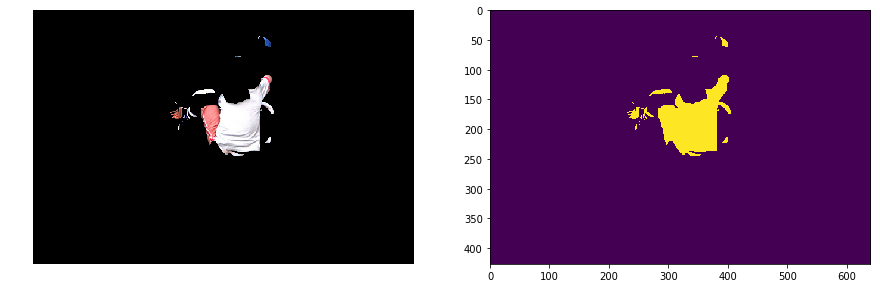

In [15]:
# Step 1
rect = tuple([int(x) for x in largest_annotation['bbox']])
grabcut.init_iteration(rect)
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 2, 1)
imshow(grabcut.get_output_image())
fig.add_subplot(1, 2, 2)
plt.imshow(grabcut.get_output_mask())

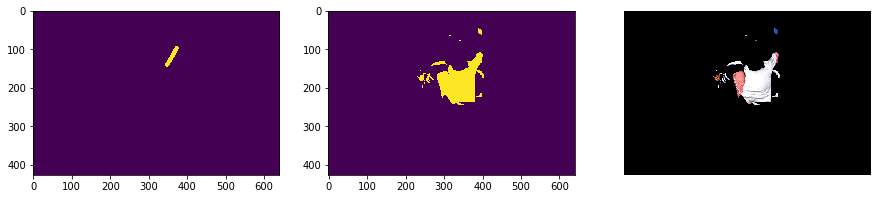

In [16]:
user_input = user_input_simulation.get_positive_line(largest_mask, grabcut.get_output_mask())
user_input
grabcut.mask_iteration(user_input)
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(user_input)
fig.add_subplot(1, 3, 2)
plt.imshow(grabcut.get_output_mask())
fig.add_subplot(1, 3, 3)
imshow(grabcut.get_output_image())

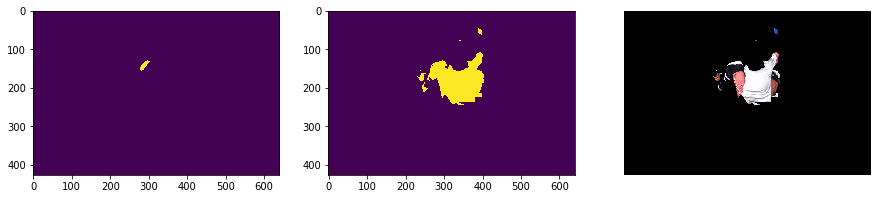

In [15]:
user_input = user_input_simulation.get_positive_line(largest_mask, grabcut.get_output_mask())
grabcut.mask_iteration(user_input)
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(user_input)
fig.add_subplot(1, 3, 2)
plt.imshow(grabcut.get_output_mask())
fig.add_subplot(1, 3, 3)
imshow(grabcut.get_output_image())

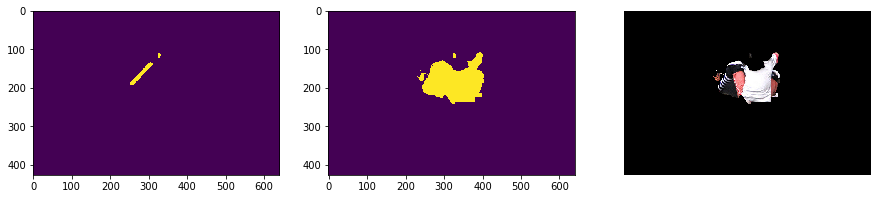

In [16]:
user_input = user_input_simulation.get_positive_line(largest_mask, grabcut.get_output_mask())
grabcut.mask_iteration(user_input)
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(user_input)
fig.add_subplot(1, 3, 2)
plt.imshow(grabcut.get_output_mask())
fig.add_subplot(1, 3, 3)
imshow(grabcut.get_output_image())

### Loop

In [30]:
grabcut = GrabCutModel(I)
mask_array = []
user_input_array = []
image_array = []

# Init
rect = tuple([int(x) for x in largest_annotation['bbox']])
grabcut.init_iteration(rect)

mask_array.append(grabcut.get_output_mask())
image_array.append(grabcut.get_output_image())
user_input_array.append(np.zeros(I.shape[:2]))

# Loop
for i in range(6):
    nr = user_input_simulation.get_negative_region(largest_mask, grabcut.get_output_mask())
    pr = user_input_simulation.get_positive_region(largest_mask, grabcut.get_output_mask())
    print(pr.sum(), nr.sum())
    if pr.sum() > nr.sum():
        user_input = user_input_simulation.get_positive_line(largest_mask, grabcut.get_output_mask())
    else:
        user_input = user_input_simulation.get_negative_line(largest_mask, grabcut.get_output_mask())
    grabcut.mask_iteration(user_input)
    mask_array.append(grabcut.get_output_mask())
    image_array.append(grabcut.get_output_image())
    user_input_array.append(user_input)

(427, 640)
11183 189
10606 191
6798 538
6374 537
3890 913
4003 2110


0.4524268104776579
0.4801636976408281
0.652602168868684
0.6727126349687441
0.7765214963707426
0.7305742870994755
0.7407848850041937


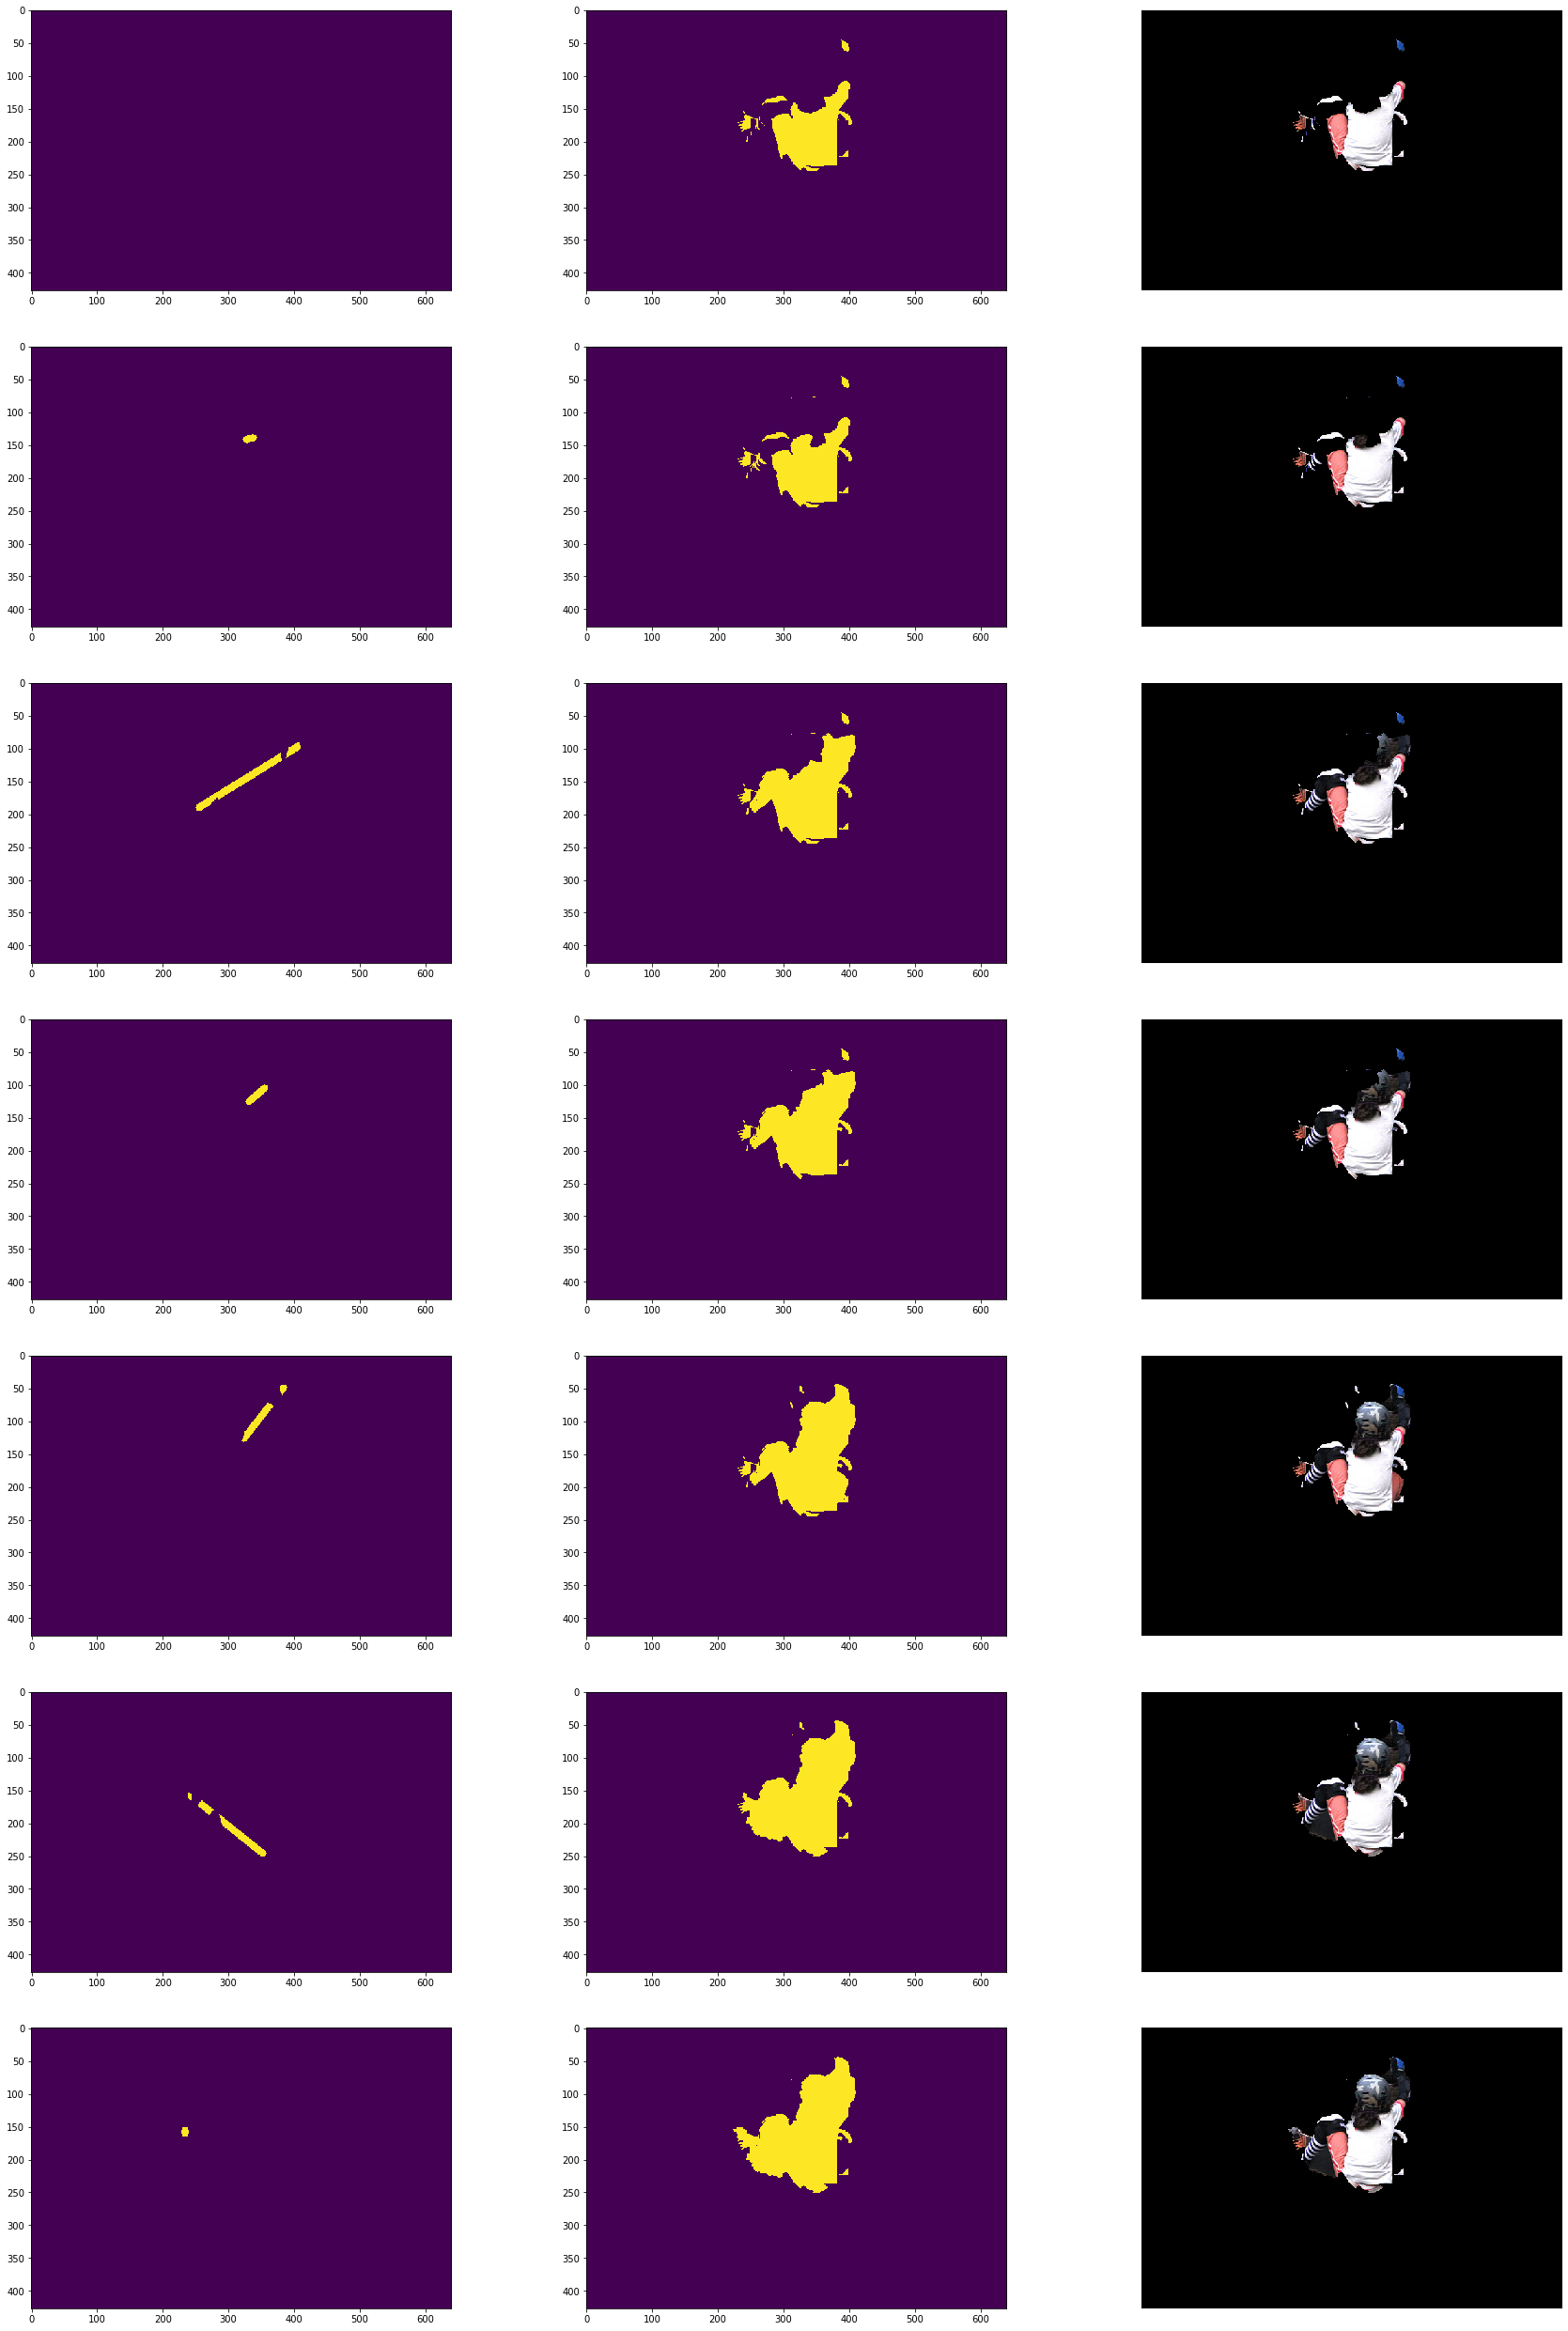

In [31]:
fig = plt.figure(figsize=(30, 45))
for i in range(7):
    print(iou(mask_array[i], largest_mask))
    fig.add_subplot(7, 3, 3*i + 1)
    plt.imshow(user_input_array[i])
    fig.add_subplot(7, 3, 3*i + 2)
    plt.imshow(mask_array[i])
    fig.add_subplot(7, 3, 3*i + 3)
    imshow(image_array[i])

### Using an automated method

In [14]:
grabcut = GrabCutModel(I)
rect = tuple([int(x) for x in largest_annotation['bbox']])
image_array, iou_array, mask_array, user_input_array = grabcut.multiple_iterations(largest_mask, rect, 20)

(427, 640)
11105 173
10076 238
8699 376
5760 531
3928 823
2545 2028
2414 2071
2189 2040
1935 2049
2143 671
1305 701
1245 700
742 2080
1631 1753
1637 1157
519 1550
602 881
628 546
531 985


0.4565343099460293
0.5045395590142672
0.5669291338582677
0.7019895783988631
0.7780114008036632
0.7977175211217764
0.8019867549668874
0.8130332905964013
0.8239349478522184
0.8675764705882353
0.9057330827067669
0.9085953287278538
0.8754578754578755
0.8484685652874798
0.8714574898785425
0.9065027791585702
0.9308946877912395
0.9444260355029586
0.9296976442218512
0.9359219676109581


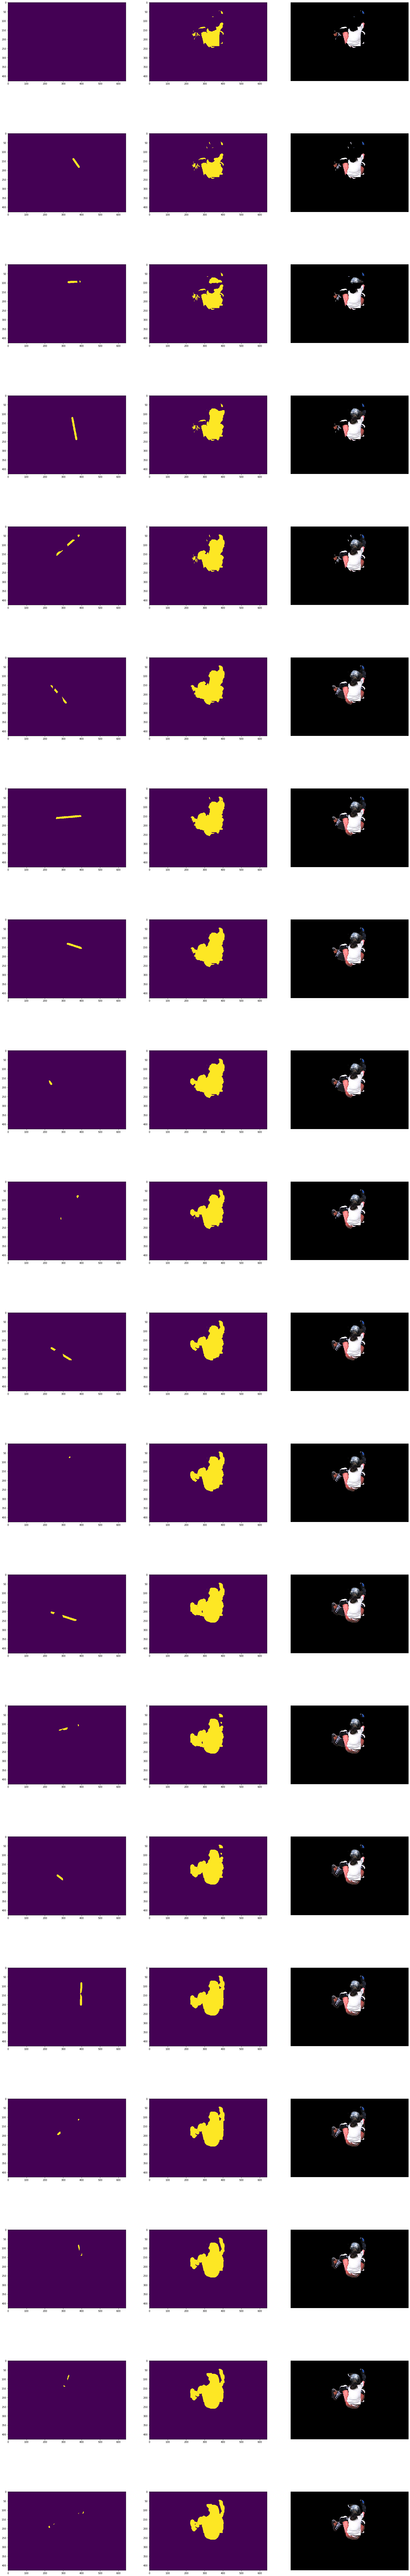

In [19]:
fig = plt.figure(figsize=(30, 200))
N = 20
for i in range(N):
    print(iou(mask_array[i], largest_mask))
    fig.add_subplot(N, 3, 3*i + 1)
    plt.imshow(user_input_array[i])
    fig.add_subplot(N, 3, 3*i + 2)
    plt.imshow(mask_array[i])
    fig.add_subplot(N, 3, 3*i + 3)
    imshow(image_array[i])